In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from io import StringIO
import requests


import matplotlib.pyplot as plt
%matplotlib inline

ARIMA Modeling

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts make the final residuals display which is a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

1st Pass of ARIMA to Extract Juice / Information:

Integrated (I) – subtract time series with its lagged series to extract trends from the data

In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for different orders of differencing are as follow:

No Differencing $(\mathrm{d}=0) \mid Y_t^{\prime}=Y_t$

$1^{\text {st }}$ Differencing ( $\left.\mathrm{d}=1\right) \mid Y_t^{\prime}=Y_t-Y_{t-1}$

$2^{\text {nd }}$ Differencing (d=2) $\mid Y_t^{\prime}=Y_t-Y_{t-1}-\left(Y_{t-1}-Y_{t-2}\right)=Y_t-2 \times Y_{t-1}+Y_{t-2}$

In [2]:
# convert to a dataframe for easy plot and differenciation

url = 'http://ucanalytics.com/blogs/wp-content/uploads/2017/08/dummy-sales.csv'
s = requests.get(url).text

random_df = pd.read_csv(StringIO(s))

random_df.set_index(pd.date_range(start='2012-01-01', freq='MS', periods=len(random_df)), inplace=True)
random_df.head(5)

,Month,Sales
2012-01-01,1,266.0
2012-02-01,2,145.9
2012-03-01,3,183.1
2012-04-01,4,119.3
2012-05-01,5,180.3


In [3]:
differenced_sales = random_df["Sales"].diff(periods=1)
differenced_sales.head(5)

2012-01-01      NaN
2012-02-01   -120.1
2012-03-01     37.2
2012-04-01    -63.8
2012-05-01     61.0
Freq: MS, Name: Sales, dtype: float64

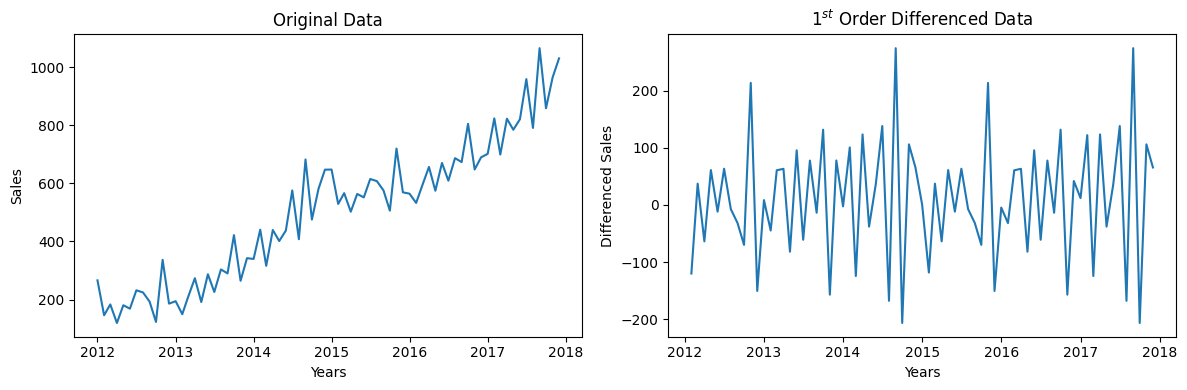

In [4]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(random_df.index, random_df['Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(random_df.index, differenced_sales)
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()


The residual data of most time series usually become trend-less after the first order differencing which is represented as ARIMA(0,1,0). Notice, AR (p), and MA (q) values in this notation are 0 and the integrated (I) value has order one. If the residual series still has a trend it is further differenced and is called 2nd order differencing. This trend-less series is called stationary on mean series i.e. mean or average value for series does not change over time and does not show any trend.

2nd Pass of ARIMA to Extract Juice / Information:

AutoRegressive (AR) – extract the influence of the previous periods’ values on the current period

After the time series data is made stationary through the integrated (I) pass, the AR part of the ARIMA juicer gets activated. As the name auto-regression suggests, here we try to extract the influence of the values of previous periods on the current period e.g. the influence of the September and October’s sales value on the November’s sales. This is done through developing a regression model with the time lagged period values as independent or predictor variables. The general form of the equation for this regression model is shown below.
$$
Y_t=c+\alpha_1 Y_{t-1}+\alpha_2 Y_{t-2}+\ldots+\alpha_p Y_{t-p}+e_t
$$
AR model of order 1 i.e. p=1 or ARIMA(1,0,0) is represented by the following regression equation
$$
Y_t=c+\alpha_1 Y_{t-1}+e_t
$$

Moving Average (MA) – extract the influence of the previous period’s error terms on the current period’s error

Finally, the last component of ARIMA juicer i.e. MA involves finding relationships between the previous periods' error terms on the current period's error term. This moving average (MA) is not connected with calculating average. Moving Average (MA) part of ARIMA is developed with the following simple multiple linear regression values with the lagged error values as independent or predictor variables.
$$
Y_t=c+e_t+\beta_1 e_{t-1}+\beta_2 e_{t-2}+\ldots+\beta_q e_{t-q}
$$
MA model of order 1 i.e. q=1 or ARIMA(0,0,1) is represented by the following regression equation
$$
Y_t=c+e_t+\beta_1 e_{t-1}
$$

White Noise & ARIMA

White noise is a funny thing, if we look at it for long we will start seeing some false patterns. This is because the human brain is wired to find patterns, and at times confuses noises with signals. The biggest proof of this is how people lose money every day on the stock market. This is precisely the reason why we need a mathematical or logical process to distinguish between a white noise and a signal (juice / information). For example, consider the following simulated white noise:

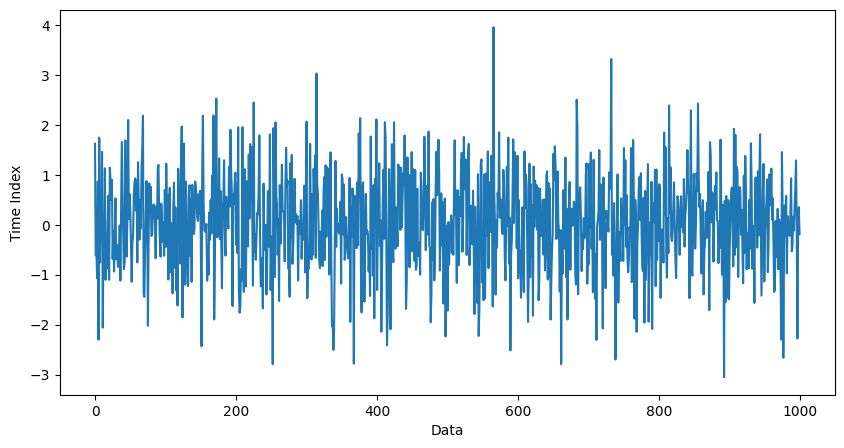

In [5]:
#generate white noise
np.random.seed(1)
plt.figure(figsize=(10,5))
white_noise = np.random.normal(size=1000)
plt.plot(white_noise)
plt.xlabel('Data')
plt.ylabel('Time Index')
plt.show()

A good way to distinguish between signal and noise is ACF (AutoCorrelation Function). This is developed by finding the correlation between a series of its lagged values. In the following ACF plot, we could see that for lag = 0 the ACF plot has the perfect correlation i.e.  ρ=1. This makes sense because any data with itself will always have the perfect correlation. However as expected, our white noise doesn't have a significant correlation with its historic values (lag >= 1). The dotted horizontal lines in the plot show the threshold for the insignificant region i.e. for a significant correlation the vertical bars should fall outside the horizontal dotted lines.

<Figure size 640x480 with 0 Axes>

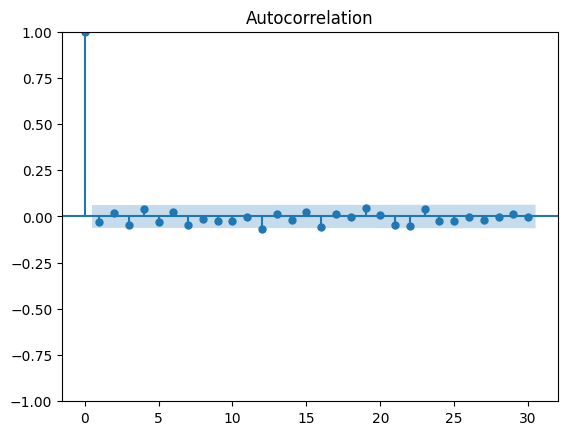

In [6]:
plt.figure()
smt.graphics.plot_acf(white_noise,lags=30,alpha=0.05)
plt.show()

- lags=30, means that the ACF plot will show the correlation of the time series with its values up to 30 periods in the past. 
- alpha=0.05 means that the confidence intervals are set at a 95% confidence level (since 1−α=0.95).If the correlation at a specific lag exceeds these bounds, it is considered statistically significant.

### Implementation ARIMA model on tractor sell dataset

Step 1: Removing the trend: 

We need to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:
$$
1^{\text {st }} \text { Differencing (d=1) } \mid Y_t^{\prime}=Y_t-Y_{t-1}
$$

In [7]:
from io import StringIO
import requests
import calendar

url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'
s = requests.get(url).text

sales_data = pd.read_csv(StringIO(s))
dates = pd.date_range(start='2003-01-01',freq='MS',periods=len(sales_data))
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data["Month"].apply(lambda x:calendar.month_abbr[x])
sales_data["Year"] = dates.year
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]


Text(0, 0.5, 'Tractor-Sales')

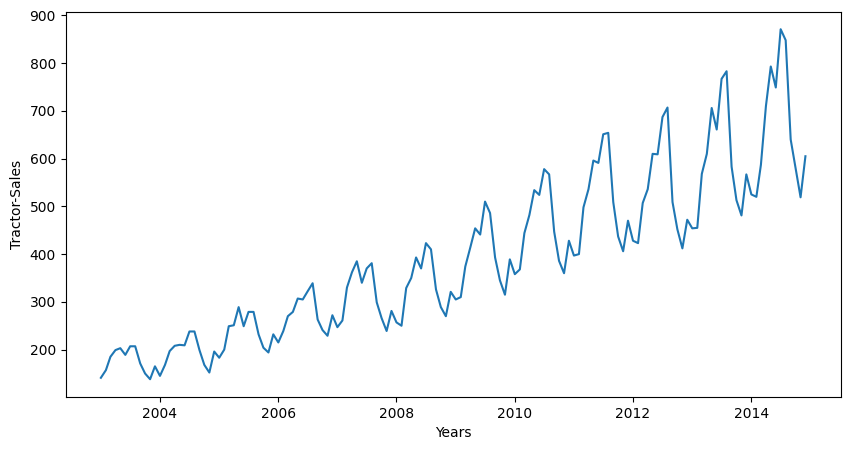

In [8]:
sales_data.set_index(dates,inplace=True)
sales_time_series = sales_data['Tractor-Sales']
plt.figure(figsize=(10,5))
plt.plot(sales_time_series)
plt.xlabel('Years')
plt.ylabel('Tractor-Sales')

Text(0, 0.5, 'Tractor Sales')

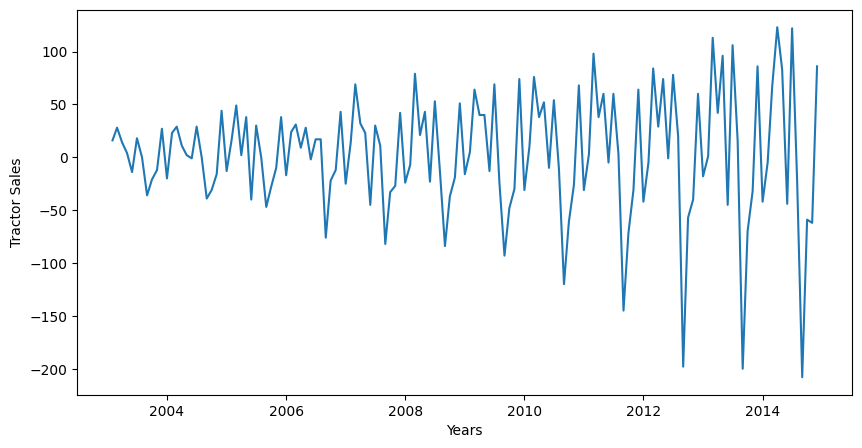

In [9]:
plt.figure(figsize=(10,5))
plt.plot(sales_time_series.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

The above series is not stationary on variance i.e. variation in the plot is increasing as we move towards the right of the chart. We need to make the series stationary on variance to produce reliable forecasts through ARIMA models.

Step 2: log transform data to make data stationary on variance: 

One of the best ways to make a series stationary on variance is through transforming the original series through log transform. Log transformation compresses the scale of large values more than smaller values. This compression reduces the impact of large fluctuations and makes the variance more uniform over time.We will go back to our original tractor sales series and log transform it to make it stationary on variance. The following equation represents the process of log transformation mathematically:
$$
\text { Log of sales : } Y_t^{\text {new }}=\log _{10}\left(Y_t\right)
$$
Notice, this series is not stationary on mean since we are using the original data without differencing. But now the series looks stationary on variance.

Text(0, 0.5, 'Log(Tractor Sales)')

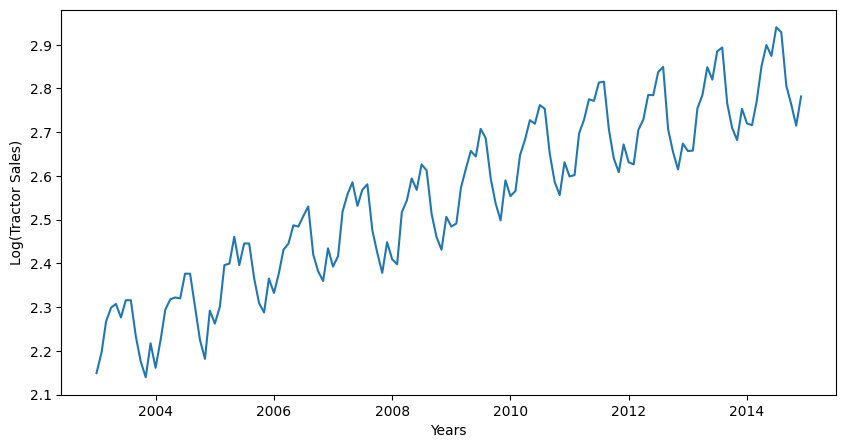

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(sales_time_series))
plt.xlabel('Years')
plt.ylabel('Log(Tractor Sales)')

Step 3: Difference log transform data to make data stationary on both mean and variance: Let us look at the differenced plot for log transformed series to reconfirm if the series is actually stationary on both mean and variance.
$$
1^{\text {st }} \text { Differencing (d=1) of Log of sales : } Y_t^{\text {new }}=\log _{10}\left(Y_t\right)-\log _{10}\left(Y_{t-1}\right)
$$

Text(0, 0.5, 'Difference Log (Tractor Sales)')

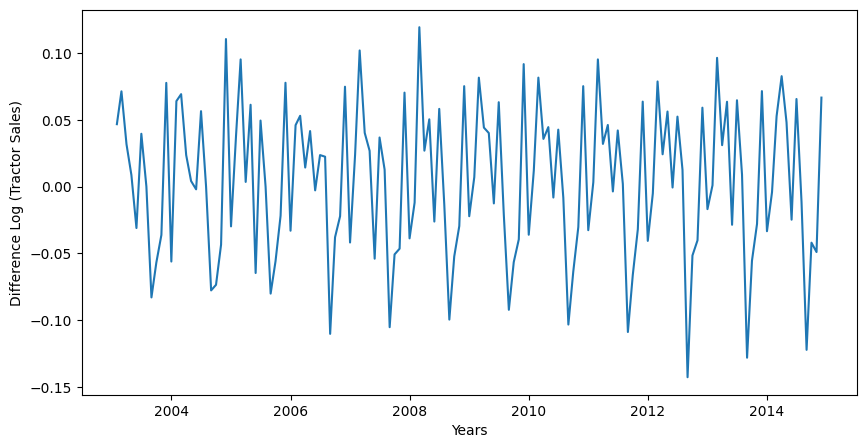

In [11]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(sales_time_series).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Difference Log (Tractor Sales)')

Yes, now this series looks stationary on both mean and variance. This also gives us the clue that I or integrated part of our ARIMA model will be equal to 1 as 1st difference is making the series stationary.

Step 4: Plot ACF and PACF to identify potential AR and MA model: 

Now, let us create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

In [12]:
sales_time_series_log = np.log10(sales_time_series)
sales_time_series_log.dropna(inplace=True)

sales_time_series_log_diff = sales_time_series_log.diff(periods=1)
sales_time_series_log_diff.dropna(inplace=True)

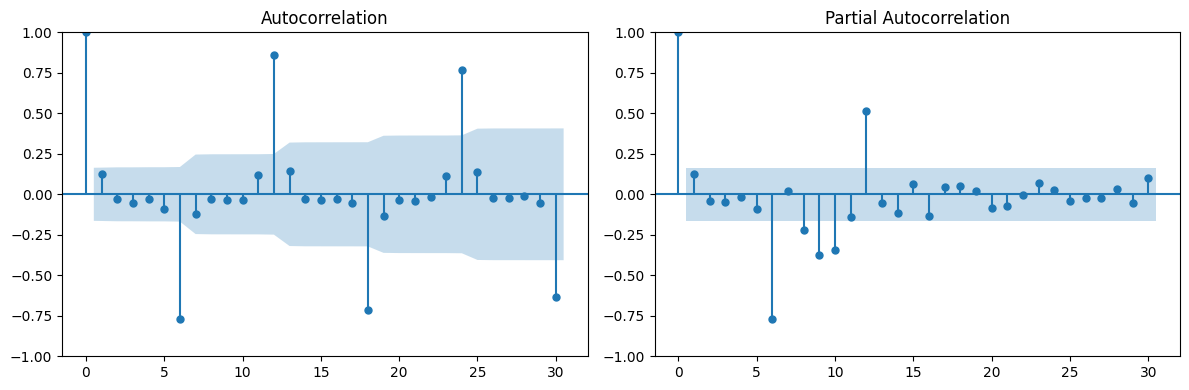

In [13]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_time_series_log_diff, lags=30, ax=axes[0], alpha=0.05)
smt.graphics.plot_pacf(sales_time_series_log_diff, lags=30, ax=axes[1], alpha=0.05)
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (horizontal blue shades) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

Step 5: Identification of best fit ARIMA model:

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC. In Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model. This technique is known as "grid search" where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

In [14]:
#define p,d,q parameters to take any value between 0 and 2
p = d = q = range(0,2)

#generate all combination of (p,d,q)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [15]:
import sys
warnings.filterwarnings("ignore")

best_aic = np.inf #store lowest AIC value
best_pdq = None #best non seasonal value
best_seasonal_pdq = None #best seasonal value
temp_model = None

for param in pdq:
    for param_seanonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_time_series_log,
                                                   order=param,
                                                   seasonal_order=param_seanonal,
                                                   enforce_stationarity=True,
                                                   enforce_invertibility=True)
            result = temp_model.fit()

            if result.aic<best_aic:
                best_aic = result.aic
                best_pdq = param
                best_seasonal_pdq = param_seanonal
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.774394375998


Non-Seasonal componenets(0,1,1)

- 0: The order of the autoregressive (AR) term, indicating no autoregressive terms.
- 1: The order of differencing (I), indicating that the data is differenced once to make it stationary.
- 1: The order of the moving average (MA) term, indicating one lag of the moving average.

Seasonal Components(1,0,1,12)

- 1: The seasonal autoregressive (SAR) term, indicating one seasonal autoregressive term.
- 0: The seasonal differencing (SI), indicating no seasonal differencing.
- 1: The seasonal moving average (SMA) term, indicating one seasonal moving average term.
- 12: The length of the seasonal cycle, indicating that the seasonality repeats every 12 periods (e.g., months in a year).

AIC

- The AIC is a measure used to compare different statistical models. It balances the goodness of fit of the model with its complexity (number of parameters).
- A lower AIC value indicates a better-fitting model, with a trade-off between accuracy and complexity. In this case, the AIC value of -733.77 is considered very good, suggesting that the model fits the data well without being overly complex.

Akaike Information Criterion (AIC) - AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so
that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

$AIC = 2K - 2ln(L)$

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum
to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC,
and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

Step 6: Predict sales on in-sample data using the best fit ARIMA model

In [16]:
best_model = sm.tsa.statespace.SARIMAX(sales_time_series_log,
                                       order=(0,1,1),
                                       seasonal_order=(1,0,1,12),
                                       enforce_invertibility=True,
                                       enforce_stationarity=True)
best_results = best_model.fit()

In [17]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Sun, 28 Jul 2024   AIC                           -733.774
Time:                                    18:28:56   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3588      0.069     -5.219      0.000      -0.493      -0.224
ar.S.L12       0.9933      0.006   

- Log Likelihood(370.887): Higher log likelihood values indicate a better fit of the model to the data. It measures how likely it is that the observed data would occur given the model parameters.
- AIC(-733.774): AIC balances model fit and complexity, penalizing models with more parameters to avoid overfitting. In this case, a very low AIC suggests a good model fit with appropriate complexity.
- BIC(-721.923): Similar to AIC, lower BIC values are better. BIC also penalizes model complexity but more strongly than AIC. Lower BIC values indicate a better model fit.
- HQIC(-728.959): Like AIC and BIC, lower HQIC values are better. 
- std err: Measures the accuracy of the coefficient estimates. Lower standard errors indicate more precise estimates.
- z: The z-value is the coefficient divided by its standard error. Higher absolute z-values indicate that the coefficient is significantly different from zero. The second z-value for ar.S.L12 is much higher than the other z-values because: The coefficient is very close to 1, indicating a strong seasonal autoregressive effect.
- p>|z|: Lower p-values (typically < 0.05) indicate that the coefficient is statistically significant. In this case, all p-values are 0, indicates that all the coefficients are highly significant.

In [18]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'),dynamic=True,full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [19]:
pred_dynamic_ci

,lower Tractor-Sales,upper Tractor-Sales
2012-01-01,2.614011,2.676252
2012-02-01,2.615943,2.689881
2012-03-01,2.700216,2.784237
2012-04-01,2.728828,2.821847
2012-05-01,2.767960,2.869179
2012-06-01,2.753535,2.862339
2012-07-01,2.795108,2.911000
2012-08-01,2.787826,2.910398
2012-09-01,2.682645,2.811551
2012-10-01,2.618776,2.753719


In [20]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_time_series_log['2012-01-01':]
# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of forecasts is 0.0011


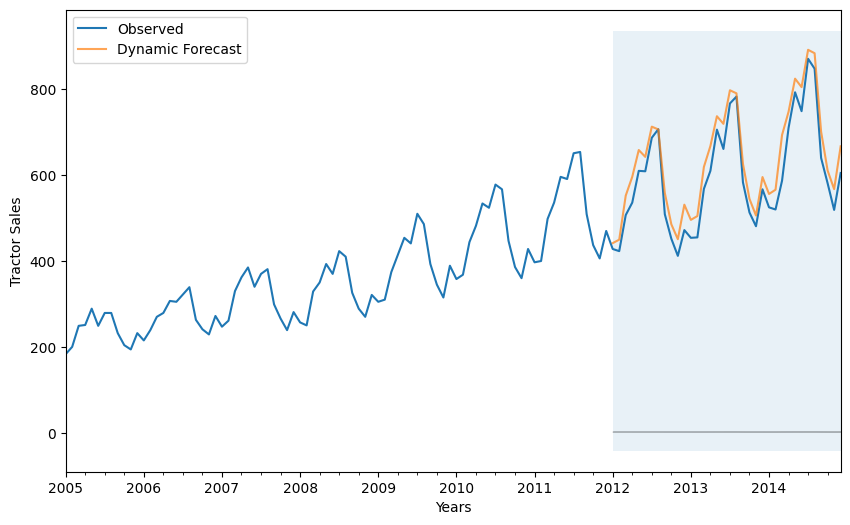

In [21]:
axis = sales_time_series['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_time_series.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

Step 7: Forecast sales using the best fit ARIMA model

The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [22]:
#get forecast 36 steps(3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36,alpha=0.01) #99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36,alpha=0.05) #95% confidence interval

In [23]:
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()
# print(pred_ci_99,pred_ci_95)

In [24]:
n_steps = 36
idx = pd.date_range(sales_time_series.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]),
index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]),
index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.479134,528.238523,609.634763,528.238523,609.634763
2015-01-01,566.221699,520.017867,616.530763,520.017867,616.530763
2015-02-01,668.856622,607.187489,736.789194,607.187489,736.789194
2015-03-01,755.232795,678.534714,840.600434,678.534714,840.600434
2015-04-01,850.254317,756.728036,955.339790,756.728036,955.339790


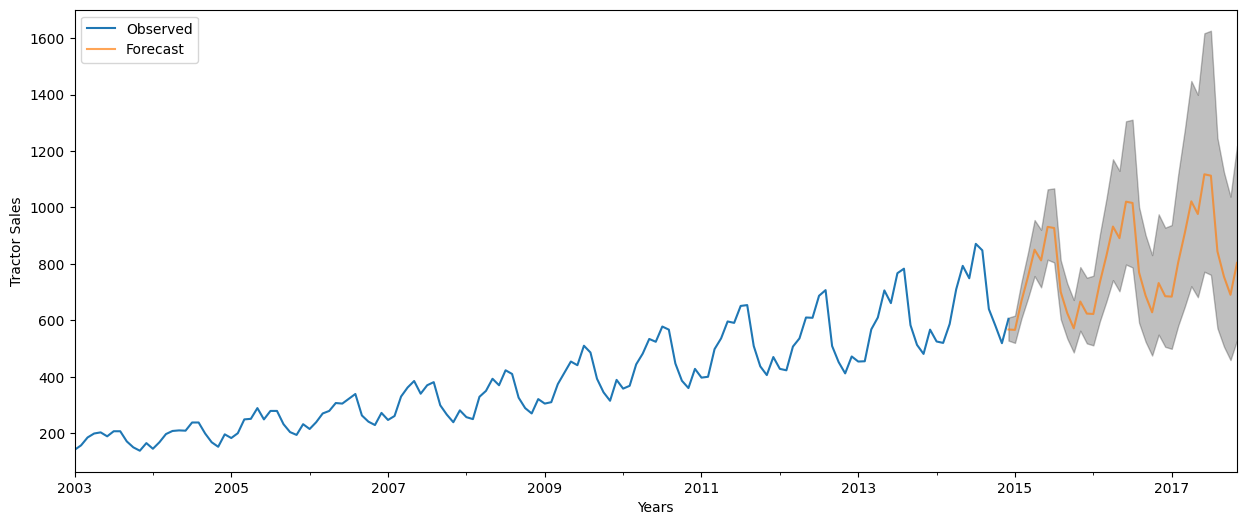

In [25]:
# plot the forecast along with the confidence band
axis = sales_time_series.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

Now, forecasts for a long period of 3 years is an ambitious task. The major assumption here is that the underlining patterns in the time series will continue to stay the same as predicted in the model. A short-term forecasting
model, say a couple of business quarters or a year, is usually a good idea to forecast with reasonable accuracy. 

Step 8: Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

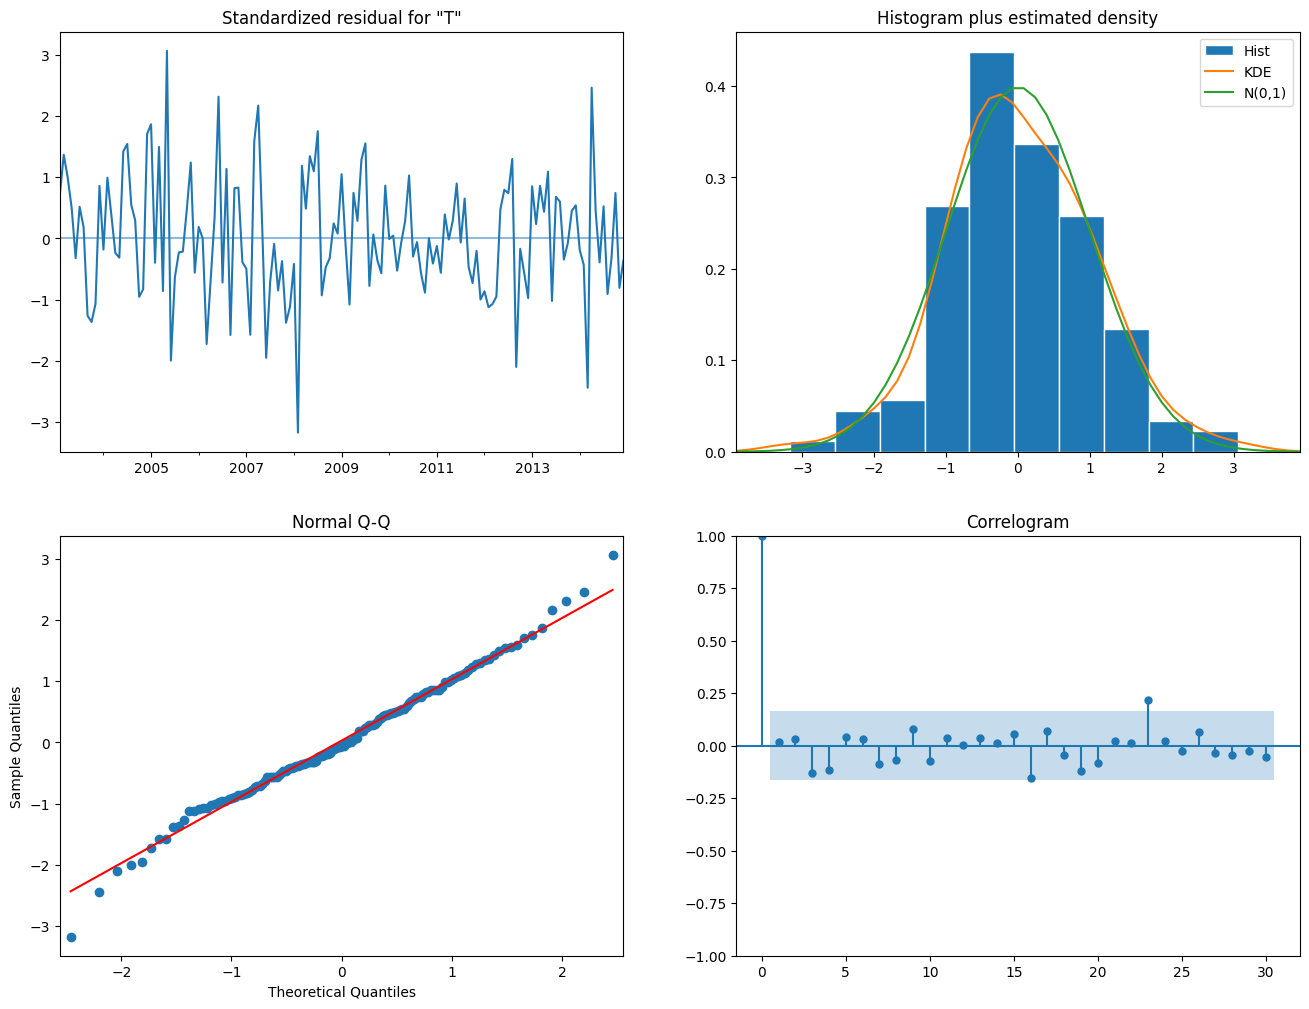

In [26]:
best_results.plot_diagnostics(lags=30,figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- The KDE(kernel density estimate) plot of the residuals on the top right is almost similar with the normal distribution(blue line).
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication
that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time
series residuals have low correlation with lagged versions of itself.


Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our
model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

Animation

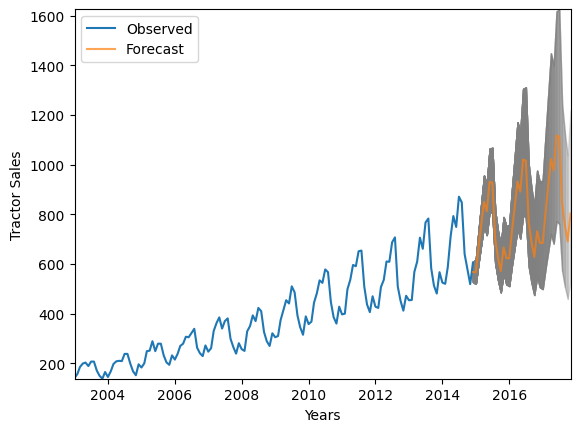

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Set the path to the FFmpeg executable
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\swati\Downloads\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe'

# Animation setup
metadata = dict(title='Forecast Animation', artist='Swati')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, ax = plt.subplots()
ax.set_xlim(sales_time_series.index[0], idx[-1])
ax.set_ylim(min(sales_time_series.min(), fc_all['lower_ci_95'].min()), max(sales_time_series.max(), fc_all['upper_ci_95'].max()))
ax.set_xlabel('Years')
ax.set_ylabel('Tractor Sales')

observed_line, = ax.plot(sales_time_series.index, sales_time_series, label='Observed')
forecast_line, = ax.plot([], [], label='Forecast', alpha=0.7)
# confidence_band_95 = ax.fill_between([], [], [], color='k', alpha=.25)
# confidence_band_99 = ax.fill_between([], [], [], color='k', alpha=.75)

plt.legend(loc='best')

# Animation function
def animate(i):
    if i < len(sales_time_series):
        observed_line.set_data(sales_time_series.index[:i+1], sales_time_series[:i+1])
    else:
        forecast_idx = idx[:i-len(sales_time_series)+1]
        forecast_data = fc_all['forecast'][:i-len(sales_time_series)+1]
        lower_ci_95 = fc_all['lower_ci_95'][:i-len(sales_time_series)+1]
        upper_ci_95 = fc_all['upper_ci_95'][:i-len(sales_time_series)+1]
        
        forecast_line.set_data(forecast_idx, forecast_data)
        # ax.collections.clear()  # Clear previous confidence bands
        ax.fill_between(forecast_idx, lower_ci_95, upper_ci_95, color='gray', alpha=.25)

# Generate animation
with writer.saving(fig, "forecast_animation.gif", 100):
    for i in range(len(sales_time_series) + len(idx)):
        animate(i)
        writer.grab_frame()